<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/28/hmm_gauss2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM with 2d Gaussian emissions 

We use the [ssm-jax](https://github.com/probml/ssm-jax/blob/main/ssm_jax/) library
to two algorithms for fitting a Gaussian HMM:
1. (Batch) EM
2. Stochastic EM

In [1]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

In [2]:
from functools import partial
from ssm_jax.hmm.models import GaussianHMM
import ssm_jax.hmm.demos.gaussian_hmm_2d as demo

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import matplotlib.pyplot as plt

**Generate sample data**

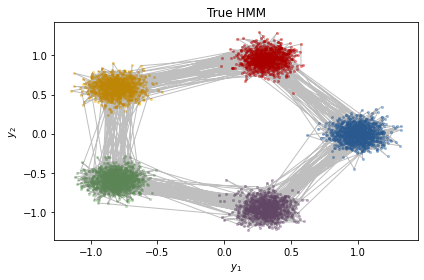

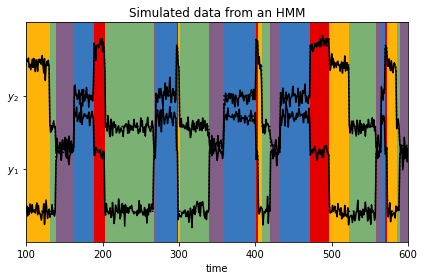

In [3]:
num_batches = 9
num_timesteps = 5000

# Make an HMM and sample data and true underlying states
# Specify parameters of the HMM
num_states = 5
emission_dim = 2
hmm = GaussianHMM(num_states, emission_dim)

params = dict(
    initial=dict(probs=jnp.ones(num_states) / num_states),
    transitions=dict(transition_matrix=0.95 * jnp.eye(num_states) + 0.05 * jnp.roll(jnp.eye(num_states), 1, axis=1)),
    emissions=dict(
        means=jnp.column_stack([
            jnp.cos(jnp.linspace(0, 2 * jnp.pi, num_states + 1))[:-1],
            jnp.sin(jnp.linspace(0, 2 * jnp.pi, num_states + 1))[:-1],
            jnp.zeros((num_states, emission_dim - 2)),
            ]),
        covs=jnp.tile(0.1**2 * jnp.eye(emission_dim), (num_states, 1, 1)))
)

# Sample data
batch_true_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_batches))

i_batch = 0
# Plot emissions and true_states in the emissions plane
demo.plot_gaussian_hmm(hmm, params, batch_emissions[0], batch_true_states[0], "True HMM");

# Plot emissions vs. time, ith background colored by true state
demo.plot_gaussian_hmm_data(hmm, params, batch_emissions[0], batch_true_states[0], xlim=(100, 600));

**Initialize test HMMs and fit to data**

Fitting via exact EM...


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]



Fitting via stochastic EM (no progress bar)...


100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


	Done


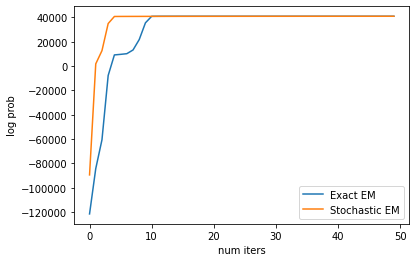

In [9]:
# Initialize HMMs, with inexact number of states
em_params, param_props = hmm.random_initialization(jr.PRNGKey(1))
sem_params, param_props = hmm.random_initialization(jr.PRNGKey(1))

# Fit
num_iters = 50

print('Fitting via exact EM...')
em_params, em_lps = hmm.fit_em(em_params, param_props, batch_emissions, num_iters)

print()
print('Fitting via stochastic EM (no progress bar)...')
minibatch_size = 3
emissions_generator = batch_emissions.reshape(num_batches // minibatch_size, minibatch_size, num_timesteps, emission_dim)
sem_params, sem_lps = hmm.fit_stochastic_em(sem_params, param_props, emissions_generator, num_epochs=num_iters)
print('\tDone')

# Plot log probs vs num_iterations
plt.plot(jnp.arange(len(em_lps)), em_lps, label='Exact EM')
plt.plot(jnp.arange(len(sem_lps)), sem_lps, label='Stochastic EM')
plt.xlabel('num iters')
plt.ylabel('log prob')
plt.legend()

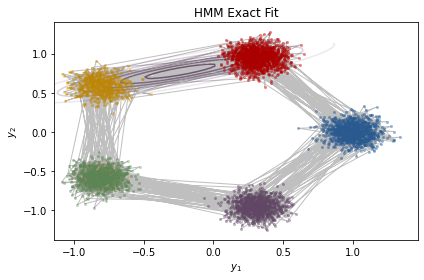

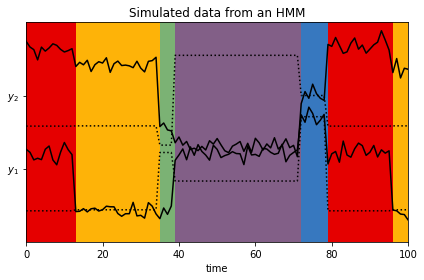

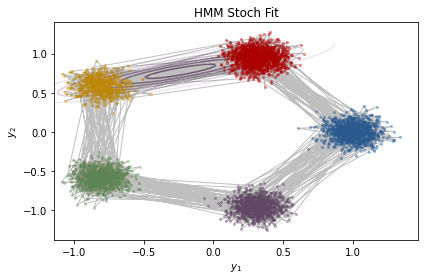

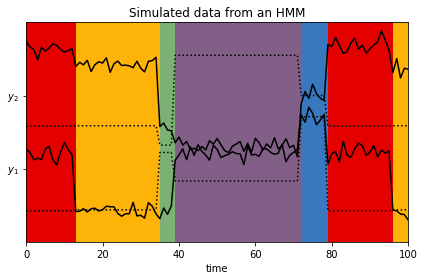

In [11]:
# TODO Recompute once we've implemented k-means initialization
# TODO plotting functions need to be able to permute

i_batch = 5

demo.plot_gaussian_hmm(hmm, em_params, batch_emissions[i_batch], batch_true_states[i_batch], "HMM Exact Fit")
demo.plot_gaussian_hmm_data(hmm, em_params, batch_emissions[i_batch], batch_true_states[i_batch], xlim=(0, 100))

demo.plot_gaussian_hmm(hmm, sem_params, batch_emissions[i_batch], batch_true_states[i_batch], "HMM Stoch Fit");
demo.plot_gaussian_hmm_data(hmm, sem_params, batch_emissions[i_batch], batch_true_states[i_batch], xlim=(0, 100));